In [8]:


import numpy as np 
import pandas as pd
import os
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, make_scorer, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils import resample
import matplotlib.pyplot as plt
from datetime import datetime
from joblib import dump, load
import mlflow.sklearn
import mlflow
from mlflow.models import infer_signature
from mlflow.tracking import MlflowClient
import sys
import seaborn as sns


from result_display import show_result, export_anomaly
from reject_anomalies import pred_baseon_threshold, make_use_reject_anomalies
from Feature_engineer import remove_unwanted_col, feature_engineer_steps




In [9]:
transactions_df = pd.read_csv("data/user_demo_data.csv")
terminal_profiles_df = pd.read_csv("data/terminal_profiles_table.csv")
customer_profiles_df = pd.read_csv("data/customer_profiles_table.csv")
join_terminal = pd.merge(transactions_df, terminal_profiles_df, on='terminal_id', how='inner') #join dataset base on key value
join_customer = pd.merge(join_terminal, customer_profiles_df, on='customer_id', how='inner')


In [10]:
# Feature engineer step and one-hot enconding for categorical feature. 
# Stored in Feature_engineer.py
train_X,train_y = feature_engineer_steps(join_customer)
#  Feature selection as part of the default pipeline
train_X = remove_unwanted_col(train_X)

In [11]:
best_model = load('saved_model/best_model_Kmeans.joblib')

In [12]:
clusters = best_model.predict(train_X)
distances = np.min(np.square(best_model.transform(train_X)), axis=1)
anomaly_threshold = np.percentile(distances, 90)
y_pred = distances > anomaly_threshold


/Users/sek/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/sek/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [13]:
report = classification_report(train_y, y_pred, output_dict=True)    
print(report)

{'0': {'precision': 0.9751111111111112, 'recall': 0.9045557616986188, 'f1-score': 0.9385092503475564, 'support': 9702.0}, '1': {'precision': 0.074, 'recall': 0.2483221476510067, 'f1-score': 0.1140215716486903, 'support': 298.0}, 'accuracy': 0.885, 'macro avg': {'precision': 0.5245555555555556, 'recall': 0.5764389546748128, 'f1-score': 0.5262654109981233, 'support': 10000.0}, 'weighted avg': {'precision': 0.948258, 'recall': 0.885, 'f1-score': 0.91393951752233, 'support': 10000.0}}


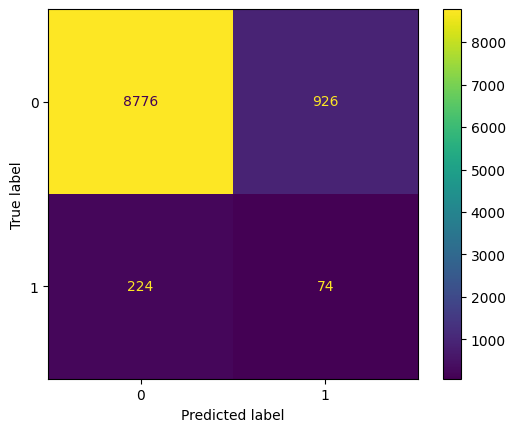

In [16]:
precision, recall, f1_socre = show_result(train_y, y_pred, "result/confusion_matrix.png")


In [17]:
#listening to port
mlflow.set_tracking_uri("http://127.0.0.1:8080")
mlflow.set_experiment("Kmeans")

2024/04/18 10:56:38 INFO mlflow.tracking.fluent: Experiment with name 'Kmeans' does not exist. Creating a new experiment.


<Experiment: artifact_location='/Users/sek/Documents/GitHub/capstone-project-9900f16agptea/mlflow_tracking_server/1', creation_time=1713401798727, experiment_id='1', last_update_time=1713401798727, lifecycle_stage='active', name='Kmeans', tags={}>

In [18]:
params = best_model.get_params()

In [19]:
# log model into mlflow
run_name = "IF_test"


# Initiate the MLflow run context
with mlflow.start_run(run_name="IF_Model_KMeans") as run:
    # Log the parameters used for the model fit
    mlflow.log_params(params)
    mlflow.log_artifact(local_path = "Feature_engineer.py")
    # mlflow.log_metrics(n_clusters)
    mlflow.log_artifact("result/confusion_matrix.png")
    # mlflow.log_artifact(anomalies)
    # mlflow.log_param("threshold", train_threshold)
    # Log an instance of the trained model for later use
    model_info = mlflow.sklearn.log_model(sk_model=best_model, artifact_path="mlruns",input_example=train_X, registered_model_name="Kmeans")
    

/Users/sek/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/Users/sek/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/sek/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:

In [20]:
best_model

KMeans(n_clusters=4, n_init=10, random_state=0)

In [21]:
params

{'algorithm': 'lloyd',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 4,
 'n_init': 10,
 'random_state': 0,
 'tol': 0.0001,
 'verbose': 0}